In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import random

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import torch.cuda
torch.cuda.is_available()

True

# Load/Preprocess data

In [337]:
def load_data(filename):
    with open(filename) as f:
        data = json.load(f)

    # Make all tracks start at 0,0
    for v in data.values():
        pos = np.array(v["txy"])
        pos -= pos[0]
        v["txy"] = pos

    # Rotate all tracks to the same orientation
    for v in data.values():
        pos = np.array(v["txy"])
        angle = -np.arctan2(pos[-1,1], pos[-1,2])
        rot = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
        pos[:,1:] = pos[:,1:] @ rot
        v["txy"] = pos

    return data

In [338]:
train_data = load_data("train.json")
test_data = load_data("test.json")

In [339]:
print(sum(1 for k in train_data.keys() if "lab" in k))
print(sum(1 for k in train_data.keys() if "sim" in k))

368
15712


## Plot some tracks

In [123]:
sim_motile_uids = [x for x in train_data.keys() if train_data[x]['label'] == 1 and 'sim' in x]
sim_nonmotile_uids = [x for x in train_data.keys() if train_data[x]['label'] == 0 and 'sim' in x]
lab_motile_uids = [x for x in train_data.keys() if train_data[x]['label'] == 1 and 'lab' in x]
lab_nonmotile_uids = [x for x in train_data.keys() if train_data[x]['label'] == 0 and 'lab' in x]

In [282]:
def plot_tracks(tracklist, title):
    # plot given tracks
    fig, ax = plt.subplots(figsize=(5,5))
    for t in tracklist:
        ax.plot(t[:,1], t[:,2])
    
    ax.set_xlim([-500, 500])
    ax.set_ylim([-100, 1000])
    ax.set_aspect(1.0)
    ax.set_title(title)

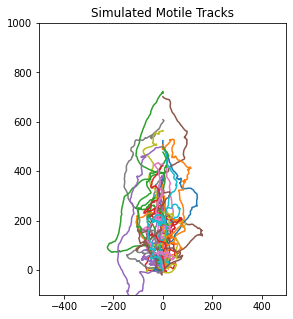

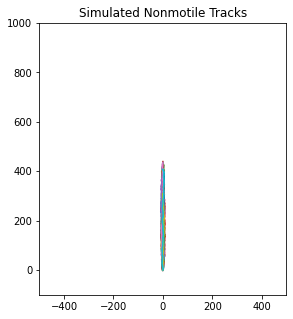

In [283]:
# Plot 10 simulated motile tracks
plot_uids = random.choices(sim_motile_uids, k=50)
to_plot = [np.array(train_data[u]['txy']) for u in plot_uids]

plot_tracks(to_plot, 'Simulated Motile Tracks')

# Plot 10 simulated nonmotile tracks
plot_uids = random.choices(sim_nonmotile_uids, k=50)
to_plot = [np.array(train_data[u]['txy']) for u in plot_uids]

plot_tracks(to_plot, 'Simulated Nonmotile Tracks')

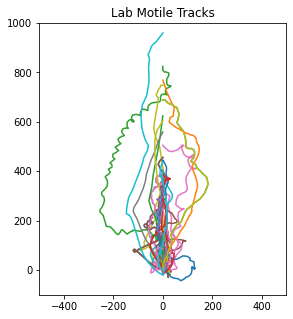

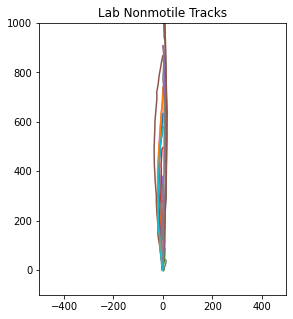

In [284]:
# Plot 10 lab motile tracks
plot_uids = random.choices(lab_motile_uids, k=50)
to_plot = [np.array(train_data[u]['txy']) for u in plot_uids]

plot_tracks(to_plot, 'Lab Motile Tracks')

# Plot 10 lab nonmotile tracks
plot_uids = random.choices(lab_nonmotile_uids, k=50)
to_plot = [np.array(train_data[u]['txy']) for u in plot_uids]

plot_tracks(to_plot, 'Lab Nonmotile Tracks')

# PyTorch

### Set up torch datasets

In [373]:
def data_to_numpy(data, shuffle=False, max_len=None, augment=False, augment_cutoff=None, augment_num=4):
    if max_len is None:
        max_len = max(len(v["txy"]) for v in data.values())

    if augment_cutoff is None:
        augment_cutoff = len(data)

    if augment:
        X = np.zeros((len(data) + augment_cutoff * augment_num, max_len, 3))
        Y = np.zeros((len(data) + augment_cutoff * augment_num, 1))
    else:
        X = np.zeros((len(data), max_len, 3))
        Y = np.zeros((len(data), 1))

    for i, v in enumerate(data.values()):
        track_len = len(v["txy"])
        X[i,:len(v["txy"]),:-1] = v["txy"][:min(track_len, max_len),1:]

        # pad with zeros
        if (track_len < max_len):
            X[i,len(v["txy"]):,:-1] = 0
            X[i,len(v["txy"]):,-1] = 1

        Y[i] = v["label"]

    if augment:
        X[len(data):] = np.repeat(X[:augment_cutoff], augment_num, axis=0)
        Y[len(data):] = np.repeat(Y[:augment_cutoff], augment_num, axis=0)

        X[len(data):,:,0] *= 2 * np.random.binomial(1, 0.5) - 1                 # randomly flip x
        X[len(data):,:,0] *= 0.9 + np.random.random(augment_cutoff * augment_num)[:,None] * 0.2  # randomly scale x
        X[len(data):,:,1] *= 0.9 + np.random.random(augment_cutoff * augment_num)[:,None] * 0.2  # randomly scale y

    # Pytorch wants (batch, channel, length)
    X = X.transpose(0,2,1)

    # Shuffle data
    if (shuffle):
        idx = np.arange(len(X))
        np.random.shuffle(idx)
        X = X[idx]
        Y = Y[idx]

    return X, Y

In [380]:
# Create training and test datasets in pytorch
X, Y = data_to_numpy(train_data, max_len=350, shuffle=True, augment=True, augment_cutoff=368, augment_num=20)
train_cutoff = int(0.8 * len(X))
train_X = torch.from_numpy(X[:train_cutoff]).float()
train_Y = torch.from_numpy(Y[:train_cutoff]).float()
test_X = torch.from_numpy(X[train_cutoff:]).float()
test_Y = torch.from_numpy(Y[train_cutoff:]).float()

train_dataset = torch.utils.data.TensorDataset(train_X, train_Y)
test_dataset = torch.utils.data.TensorDataset(test_X, test_Y)

In [381]:
train_X.shape, test_X.shape

(torch.Size([18752, 3, 350]), torch.Size([4688, 3, 350]))

In [382]:
# Construct a test set of only lab data
lab_data = {k:v for k,v in train_data.items() if 'lab' in k}
X, Y = data_to_numpy(lab_data, shuffle=False, max_len=350, augment=True)
lab_X = torch.from_numpy(X).float()
lab_Y = torch.from_numpy(Y).float()
lab_dataset = torch.utils.data.TensorDataset(lab_X, lab_Y)

## Create model

In [394]:
torch.manual_seed(10)

model = nn.Sequential(
    nn.Conv1d(3, 10, 5, padding=2),
    nn.BatchNorm1d(10),
    nn.ReLU(),
    nn.Conv1d(10, 30, 5, padding=2),
    nn.BatchNorm1d(30),
    nn.ReLU(),
    nn.MaxPool1d(2),

    nn.Conv1d(30, 30, 5, padding=2),
    nn.BatchNorm1d(30),
    nn.ReLU(),
    nn.Conv1d(30, 20, 5, padding=2),
    nn.BatchNorm1d(20),
    nn.ReLU(),
    nn.MaxPool1d(2),

    nn.Flatten(),
    nn.Linear(20 * (train_X.shape[-1] // 4), 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
).cuda()

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

## Functions for training/testing

In [388]:
def train(n_epochs, batch_size=32):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model.train()

    train_losses = []
    test_losses = []

    loss_eval_interval = 5000 // batch_size

    for epoch in tqdm(range(n_epochs)):
        running_loss = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            pred = model(data)
            loss = loss_fn(pred, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if batch_idx % loss_eval_interval == loss_eval_interval - 1:
                train_losses.append(running_loss / (loss_eval_interval))
                running_loss = 0

                test_loss = 0
                with torch.no_grad():
                    for data, target in test_loader:
                        data, target = data.cuda(), target.cuda()
                        pred = model(data)
                        loss = loss_fn(pred, target)
                        test_loss += loss.item()

                test_losses.append(test_loss / (len(test_loader)))

        print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

    return train_losses, test_losses

In [389]:
# Test model, print accuracy and f2 score
def test(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

    model.eval()

    test_loss = 0
    correct = 0

    true_pos = 0
    false_pos = 0
    true_neg = 0
    false_neg = 0

    with torch.no_grad():
        for data, target in loader:
            data, target = data.cuda(), target.cuda()

            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output > 0
            correct += pred.eq(target.view_as(pred)).sum().item()

            true_pos += ((pred == 1) & (target == 1)).sum().item()
            false_pos += ((pred == 1) & (target == 0)).sum().item()
            true_neg += ((pred == 0) & (target == 0)).sum().item()
            false_neg += ((pred == 0) & (target == 1)).sum().item()

    test_loss /= len(loader)

    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    f2 = (5 * precision * recall) / (4 * precision + recall)

    print(f"Test loss: {test_loss:.4f}")
    print(f"Accuracy: {correct / len(loader.dataset):.4f} ({correct}/{len(loader.dataset)})")
    print(f"F2 score: {f2:.4f}")

## Train Model

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.3184, Test Loss: 0.2887
Epoch 2, Train Loss: 0.1997, Test Loss: 0.1960
Epoch 3, Train Loss: 0.1504, Test Loss: 0.1605
Epoch 4, Train Loss: 0.1279, Test Loss: 0.1364
Epoch 5, Train Loss: 0.1230, Test Loss: 0.1202
Epoch 6, Train Loss: 0.1016, Test Loss: 0.1089
Epoch 7, Train Loss: 0.0935, Test Loss: 0.0955
Epoch 8, Train Loss: 0.0816, Test Loss: 0.0854
Epoch 9, Train Loss: 0.0892, Test Loss: 0.0827
Epoch 10, Train Loss: 0.0722, Test Loss: 0.0748
Epoch 11, Train Loss: 0.0717, Test Loss: 0.0735
Epoch 12, Train Loss: 0.0585, Test Loss: 0.0671
Epoch 13, Train Loss: 0.0606, Test Loss: 0.0659
Epoch 14, Train Loss: 0.0571, Test Loss: 0.0622
Epoch 15, Train Loss: 0.0538, Test Loss: 0.0600
Epoch 16, Train Loss: 0.0494, Test Loss: 0.0555
Epoch 17, Train Loss: 0.0440, Test Loss: 0.0602
Epoch 18, Train Loss: 0.0456, Test Loss: 0.0501
Epoch 19, Train Loss: 0.0478, Test Loss: 0.0501
Epoch 20, Train Loss: 0.0421, Test Loss: 0.0480
Epoch 21, Train Loss: 0.0454, Test Loss: 0.0486
E

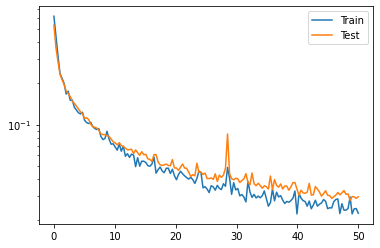

In [395]:
train_losses, test_losses = train(50, 64)

# Plot learning curve
epoch_steps = np.linspace(0, 50, len(train_losses))
plt.plot(epoch_steps, train_losses, label='Train')
plt.plot(epoch_steps, test_losses, label='Test')
plt.legend()
plt.yscale('log')

In [397]:
test(test_dataset)
print()
test(lab_dataset)

Test loss: 0.0192
Accuracy: 0.9940 (4660/4688)
F2 score: 0.9927

Test loss: 0.0087
Accuracy: 1.0000 (1840/1840)
F2 score: 1.0000


## Generate submission data

In [398]:
X, _ = data_to_numpy(test_data, shuffle=False, max_len=350)
torch_X = torch.from_numpy(X).float().cuda()
model.eval()
with torch.no_grad():
    output = model(torch_X).cpu()

In [399]:
import csv

# Create submission file
with open('submission.csv', 'w', newline='') as f:
    writer = csv.writer(f)

    writer.writerow(["UID", "label"])

    for i, k in enumerate(test_data.keys()):
        pred = int(output[i].item() > 0)
        writer.writerow([k, pred])